<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Исследование-задачи" data-toc-modified-id="Исследование-задачи-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Исследование задачи</a></span></li><li><span><a href="#Борьба-с-дисбалансом" data-toc-modified-id="Борьба-с-дисбалансом-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Борьба с дисбалансом</a></span></li><li><span><a href="#Тестирование-модели" data-toc-modified-id="Тестирование-модели-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование модели</a></span></li><li><span><a href="#Чек-лист-готовности-проекта" data-toc-modified-id="Чек-лист-готовности-проекта-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист готовности проекта</a></span></li></ul></div>

# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

**Признаки:**
- RowNumber — индекс строки в данных
- CustomerId — уникальный идентификатор клиента
- Surname — фамилия
- CreditScore — кредитный рейтинг
- Geography — страна проживания
- Gender — пол
- Age — возраст
- Tenure — сколько лет человек является клиентом банка
- Balance — баланс на счёте
- NumOfProducts — количество продуктов банка, используемых клиентом
- HasCrCard — наличие кредитной карты
- IsActiveMember — активность клиента
- EstimatedSalary — предполагаемая зарплата

**Целевой признак:**
- Exited — факт ухода клиента

<div class="alert alert-success">
<b>Комментарий ревьюера ✔️:</b>

Вступление в работу очень важно. Так ты поясняешь то, чему она посвящена 👍

</div>

## Подготовка данных

In [2]:
import pandas as pd
import numpy as np
#подготовка данных
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.utils import shuffle
#модели машинного обучения
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
#метрики модели
from sklearn.metrics import confusion_matrix, f1_score, roc_curve, roc_auc_score, RocCurveDisplay
import matplotlib.pyplot as plt

## Исследование задачи

In [3]:
data = pd.read_csv('/datasets/Churn.csv')
data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [50]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


**Предобработка:**
- Для задачи обучения лишними будут столбцы с индексом строки данных, ID клиента и его фамилией, также уберем значения с NA в столбце Tenure (-10% от исходного датафрейма)
- Отделить целевой признак
- С помощью техники One Hot Encoding закодировать категориальные переменные - пол и страну проживания клиента
- Стандартизировать столбцы с кредитным рейтингом, возрастом, числом лет в качестве клиента банка и количеством используемых продуктов
- Разделить датасет на обучающую, валидационную и тестовую выборки

In [51]:
#удаление лишних столбцов
data_drop = data.drop(columns=['RowNumber', 'CustomerId', 'Surname'])
data_drop = data_drop[~data_drop['Tenure'].isna()]
data_drop.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [52]:
data_drop.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9091 entries, 0 to 9998
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      9091 non-null   int64  
 1   Geography        9091 non-null   object 
 2   Gender           9091 non-null   object 
 3   Age              9091 non-null   int64  
 4   Tenure           9091 non-null   float64
 5   Balance          9091 non-null   float64
 6   NumOfProducts    9091 non-null   int64  
 7   HasCrCard        9091 non-null   int64  
 8   IsActiveMember   9091 non-null   int64  
 9   EstimatedSalary  9091 non-null   float64
 10  Exited           9091 non-null   int64  
dtypes: float64(3), int64(6), object(2)
memory usage: 852.3+ KB


In [53]:
#отделение целевого признака
target = data_drop['Exited']
features = data_drop.drop(columns=['Exited'], axis=1)

In [54]:
#OHE
features = pd.get_dummies(features, drop_first=True)
features.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
0,619,42,2.0,0.00,1,1,1,101348.88,0,0,0
1,608,41,1.0,83807.86,1,0,1,112542.58,0,1,0
2,502,42,8.0,159660.80,3,1,0,113931.57,0,0,0
3,699,39,1.0,0.00,2,0,0,93826.63,0,0,0
4,850,43,2.0,125510.82,1,1,1,79084.10,0,1,0


In [55]:
#деление на выборки в соотношении 60-20-20
features_train, features_test_valid, target_train, target_test_valid = train_test_split(features, target, 
                                                                                        test_size=.4, random_state=123, stratify=target)
features_test, features_valid, target_test, target_valid = train_test_split(features_test_valid, target_test_valid, 
                                                                                        test_size=.5, random_state=123, stratify=target_test_valid)
print('Размер обучающей выборки:',features_train.shape, target_train.shape)
print('Размер валидационной выборки:',features_valid.shape, target_valid.shape)
print('Размер тестовой выборки:', features_test.shape, target_test.shape)

Размер обучающей выборки: (5454, 11) (5454,)
Размер валидационной выборки: (1819, 11) (1819,)
Размер тестовой выборки: (1818, 11) (1818,)


In [56]:
#стандартизация
scaler = StandardScaler()
#названия столбцов для стандартизации
numeric = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']
scaler.fit(features_train[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])


/tmp/ipykernel_71/3370140273.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_train[numeric] = scaler.transform(features_train[numeric])
/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
/tmp/ipykernel_71/3370140273.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See t

In [57]:
features_train.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
9491,-0.003468,-0.386878,-0.345322,0.518846,-0.917266,1,1,1.597885,0,0,0
9174,-1.252595,2.063796,-1.378636,-1.222143,0.805450,1,1,1.578646,0,0,1
6215,-1.002769,0.178663,0.343554,1.108274,-0.917266,1,1,-1.388924,0,1,1
5711,-0.336568,-0.386878,-1.034198,0.457789,-0.917266,1,1,0.824195,0,0,0
5664,0.183901,3.006363,-0.345322,0.984278,-0.917266,0,1,-0.093601,0,1,1


In [58]:
features_test.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
9308,0.964605,-1.140931,-1.723074,-1.222143,0.805450,0,1,0.546433,0,0,1
6769,1.172793,0.461433,0.687992,1.338818,-0.917266,0,0,-1.295163,0,0,0
530,-1.356689,1.686769,-1.034198,0.691310,0.805450,1,1,-1.207329,0,1,0
150,1.089518,-0.669648,0.687992,-1.222143,0.805450,1,0,-0.178342,0,1,0
4609,-0.711306,-0.481134,-1.378636,-1.222143,0.805450,0,1,-0.322308,0,1,1


In [59]:
features_valid.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
6833,0.267176,-0.481134,1.721306,0.143312,-0.917266,0,0,0.799943,0,0,0
621,0.069398,0.084406,1.721306,1.476447,-0.917266,0,1,0.897522,0,1,0
9247,1.422619,-0.952418,0.687992,0.078224,0.805450,1,0,-0.602281,0,1,1
3228,-0.690488,-0.952418,1.721306,-1.222143,0.805450,1,1,0.197121,0,0,0
8819,-0.596803,-0.292621,1.721306,0.758055,-0.917266,0,1,0.797886,1,0,1


In [60]:
#задаем гиперпараметры
lr_params = {'C': np.logspace(-5, 5, 20)}
dtc_params = {'criterion': ['gini', 'entropy'], 'max_depth': range(1,10)}
rfc_params = {'criterion': ['gini', 'entropy'], 'max_depth': range(1,10), 'n_estimators': [100, 200, 300]}

#перебираем модели с помощью GridSearch и обучаем их на тренировочном датасете
print('Ищем лучшую модель логистической регрессии...')
logreg = GridSearchCV(LogisticRegression(random_state=12345), lr_params, scoring='f1', cv=10)
best_logreg = logreg.fit(features_train, target_train)
print('Лучшая модель логистической регрессии: ', best_logreg.best_estimator_, '\n')

print('Ищем лучшую модель дерева решений...')
clf = GridSearchCV(DecisionTreeClassifier(random_state=12345), dtc_params, scoring='f1', cv=10)
best_clf = clf.fit(features_train, target_train)
print('Лучшая модель дерева решений: ', best_clf.best_estimator_, '\n')

print('Ищем лучшую модель случайного леса...')
rf_clf = GridSearchCV(RandomForestClassifier(random_state=12345), rfc_params, scoring='f1', cv=10)
best_rf_clf = rf_clf.fit(features_train, target_train)
print('Лучшая модель случайного леса: ', best_rf_clf.best_estimator_, '\n')

Ищем лучшую модель логистической регрессии...
Лучшая модель логистической регрессии:  LogisticRegression(C=20.6913808111479, random_state=12345) 

Ищем лучшую модель дерева решений...
Лучшая модель дерева решений:  DecisionTreeClassifier(max_depth=8, random_state=12345) 

Ищем лучшую модель случайного леса...
Лучшая модель случайного леса:  RandomForestClassifier(criterion='entropy', max_depth=9, random_state=12345) 



Проверим метрики лучших моделей

In [61]:
best_logreg.best_score_

0.3128924457396082

In [62]:
best_clf.best_score_

0.5626300405559523

In [63]:
best_rf_clf.best_score_

0.5623086754329027

Лучше всего себя показала модель дерева решений с максимальной глубиной дерева 8.

In [64]:
#функция построения ROC curve и вычисления показателя ROC-AUC 
def roc_auc_viz(model, features, target, sample_name=None):
    
    probabilities = model.predict_proba(features)

    fpr, tpr, _ = roc_curve(target, probabilities[:, 1])
    roc_auc = roc_auc_score(target, probabilities[:, 1])

    plt
    display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                estimator_name=f'ROC-AUC ({sample_name.lower()})')
    display.plot()
    plt.plot([0, 1], [0, 1], linestyle='--')
    if sample_name == None:
        plt.title('ROC-кривая')
        plt.show()
        print('ROC-AUC: ', auc_roc)
    else:
        plt.title(f'ROC-кривая ({sample_name.lower()})')
        plt.show()
        print(f'ROC-AUC ({sample_name.lower()}): ', roc_auc)
    return roc_auc

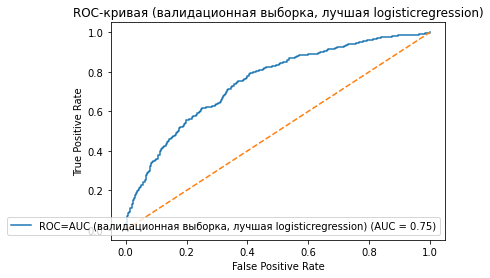

ROC-AUC (валидационная выборка, лучшая logisticregression):  0.7483525934088844


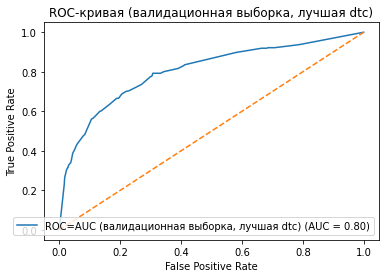

ROC-AUC (валидационная выборка, лучшая dtc):  0.802815669163527


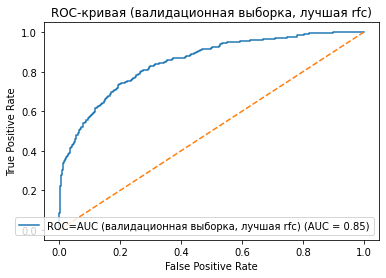

ROC-AUC (валидационная выборка, лучшая rfc):  0.8492222751708836


,model,f1,roc_auc
0,Лучшая LogisticRegression,0.293651,0.748353
1,Лучшая DTC,0.526149,0.802816
2,Лучшая RFC,0.520211,0.849222


In [65]:
models = {'Лучшая LogisticRegression': best_logreg, 'Лучшая DTC': best_clf, 'Лучшая RFC': best_rf_clf}
models_validation = []
for m in models.keys():
    predictions = models[m].predict(features_valid)
    f1 = f1_score(target_valid, predictions)
    roc_auc = roc_auc_viz(models[m], features_valid, target_valid, sample_name=f'валидационная выборка, {m}')
    models_validation.append({'model': m, 'f1': f1, 'roc_auc': roc_auc})
pd.DataFrame(models_validation)

Дерево решений оказалось лучшей моделью с точки зрения F1-меры, однако модель случайного леса имеет лучший показатель ROC-AUC, а F1-мера на 0.006 уступает дереву решений.

Округленные значения F1-меры для валидационной выборки не превышают 0,52. 

**Выводы:**
- удалены столбцы с индексом строки данных, ID клиента и его фамилией, строки с значением NA в столбце Tenure (-10% от исходного датафрейма)
- отделен целевой признак - уход клиента из банка
- с помощью техники One Hot Encoding закодированы категориальные переменные - пол и страну проживания клиента
- стандартизированы столбцы с кредитным рейтингом, возрастом, числом лет в качестве клиента банка и количеством используемых продуктов
- датасет разделен на обучающую (60%), валидационную (20%) и тестовую выборки (20%)
- без учета дисбаланса классов лучше всего показала себя модель случайного леса. Удалось довести значение F1-меры до 0,52  и ROC-AUC до 0,85 в валидационной выборке

## Борьба с дисбалансом

Проверим соотношение значений в целевом признаке

In [68]:
target_train.value_counts(normalize=True)

0    0.796113
1    0.203887
Name: Exited, dtype: float64

In [69]:
target.value_counts(normalize=True)

0    0.796062
1    0.203938
Name: Exited, dtype: float64

Наблюдается дисбаланс классов: услугами банка прекращает пользоваться каждый пятый клиент. Попробуем увеличить число ушедших клиентов.

In [70]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

features_train_up, target_train_up = upsample(features_train, target_train, 4)
print('Размер обычной обучающей выборки:', features_train.shape, target_train.shape)
print('Размер увеличенной обучающей выборки:', features_train_up.shape, target_train_up.shape)
print('Баланс классов в обычной обучающей выборке:', target_train.value_counts(normalize=True), sep='\n')
print('Баланс классов в увеличенной обучающей выборке:', target_train_up.value_counts(normalize=True), sep='\n')

Размер обычной обучающей выборки: (5454, 11) (5454,)
Размер увеличенной обучающей выборки: (8790, 11) (8790,)
Баланс классов в обычной обучающей выборке:
0    0.796113
1    0.203887
Name: Exited, dtype: float64
Баланс классов в увеличенной обучающей выборке:
1    0.50603
0    0.49397
Name: Exited, dtype: float64


**Вывод:** из-за небольшого количества данных в датасете в 4 раза увеличено число ушедших клиентов в тренировочной выборке.

## Тестирование модели

In [71]:
%%time
#перебираем параметр C в логистической регрессии и ищем лучшую модель на валидации
best_models_f1 = {}
print('Ищем лучшую модель логистической регрессии...')
for c in np.logspace(-5, 5, 20):
    logreg = LogisticRegression(random_state=12345, C=c, solver='liblinear')
    logreg.fit(features_train_up, target_train_up)
    predictions = logreg.predict(features_valid)
    f1 = f1_score(target_valid, predictions)
    best_models_f1[f'Модель LogisticRegression(random_state=12345, C={c}, solver="liblinear")'] = f1
print(f'Лучшая модель: {max(best_models_f1, key=best_models_f1.get)}')
print(f'F1-мера (валидационная выборка)={max(best_models_f1.values())}')


Ищем лучшую модель логистической регрессии...
Лучшая модель: Модель LogisticRegression(random_state=12345, C=0.0012742749857031334, solver="liblinear")
F1-мера (валидационная выборка)=0.4894259818731117
CPU times: user 1.11 s, sys: 1.74 s, total: 2.84 s
Wall time: 2.79 s


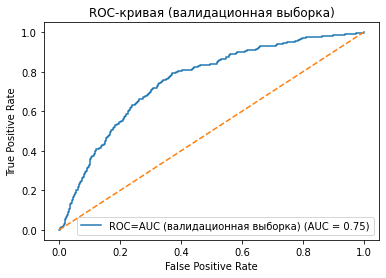

ROC-AUC (валидационная выборка):  0.7539165462911945


0.7539165462911945

In [72]:
best_logreg = LogisticRegression(random_state=12345, C=0.0012742749857031334, solver='liblinear')
best_logreg.fit(features_train_up, target_train_up)
roc_auc_viz(best_logreg, features_valid, target_valid, sample_name=f'валидационная выборка')

In [73]:
best_models_f1 = {}
print('Ищем лучшую модель дерева решений...')
for crit in ['gini', 'entropy']:
    for max_d in range(1,15):
        for class_w in [None, 'balanced']:
            dtc = DecisionTreeClassifier(random_state=12345, criterion=crit, max_depth=max_d, class_weight=class_w)
            dtc.fit(features_train_up, target_train_up)
            predictions = dtc.predict(features_valid)
            f1 = f1_score(target_valid, predictions)
            
            best_models_f1[f'DecisionTreeClassifier(random_state=12345, criterion={crit}, max_depth={max_d}, class_weight={class_w})'] = f1
print(f'Лучшая модель: {max(best_models_f1, key=best_models_f1.get)}')
print(f'F1-мера (валидационная выборка)={max(best_models_f1.values())}')

Ищем лучшую модель дерева решений...
Лучшая модель: DecisionTreeClassifier(random_state=12345, criterion=gini, max_depth=5, class_weight=None)
F1-мера (валидационная выборка)=0.5978947368421053


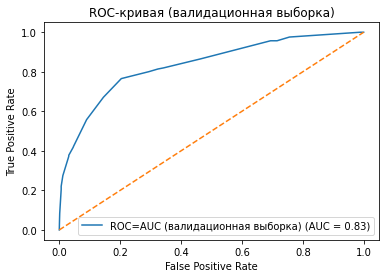

ROC-AUC (валидационная выборка):  0.8346431922086045


0.8346431922086045

In [74]:
best_dtc = DecisionTreeClassifier(random_state=12345, criterion='gini', max_depth=5, class_weight=None)
best_dtc.fit(features_train_up, target_train_up)
roc_auc_viz(best_dtc, features_valid, target_valid, sample_name=f'валидационная выборка')

In [80]:
%%time
best_models_f1 = {}
print('Ищем лучшую модель случайного леса...')
for crit in ['gini', 'entropy']:
    for max_d in range(1,15):
        for class_w in [None, 'balanced']:
            for n_est in [100, 200, 300]:
                rfc = RandomForestClassifier(random_state=12345, criterion=crit, max_depth=max_d, class_weight=class_w, n_estimators=n_est)
                rfc.fit(features_train_up, target_train_up)
                predictions = rfc.predict(features_valid)
                f1 = f1_score(target_valid, predictions)
                best_models_f1[f'RandomForestClassifier(random_state=12345, criterion={crit}, max_depth={max_d}, class_weight={class_w}), n_estimators={n_est})'] = f1
print(f'Лучшая модель: {max(best_models_f1, key=best_models_f1.get)}')
print(f'F1-мера (валидационная выборка)={max(best_models_f1.values())}')

Ищем лучшую модель случайного леса...
Лучшая модель: RandomForestClassifier(random_state=12345, criterion=entropy, max_depth=10, class_weight=None), n_estimators=200)
F1-мера (валидационная выборка)=0.6081582200247219
CPU times: user 3min 36s, sys: 2.44 s, total: 3min 38s
Wall time: 3min 39s


Лучше всего на валидации себя показала модель случайного леса с максимальной глубиной дерева 10 и критерием entropy. Для нее и рассчитаем F1-score и ROC-AUC тестовой модели.

In [81]:
best_rfc = RandomForestClassifier(random_state=12345, criterion='entropy', max_depth=10, class_weight=None, n_estimators=200)
best_rfc.fit(features_train_up, target_train_up)

pred_valid = best_rfc.predict(features_valid)
print(f'F1-мера (валидационная выборка): {f1_score(target_valid, pred_valid)}')

F1-мера (валидационная выборка): 0.6081582200247219


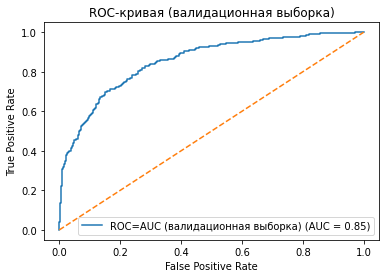

ROC-AUC (валидационная выборка):  0.85287449181695


0.85287449181695

In [82]:
roc_auc_viz(best_rfc, features_valid, target_valid, sample_name='валидационная выборка')

Округленные значения F1-меры лучших моделей дерева решений и случайного леса валидационной превышают 0,59. Лучше показал себя случайный лес. Проверим на тестовой выборке.

In [83]:
pred_test = best_rfc.predict(features_test)
print(f'F1-мера (тестовая выборка): {f1_score(target_test, pred_test)}')

F1-мера (тестовая выборка): 0.6041923551171393


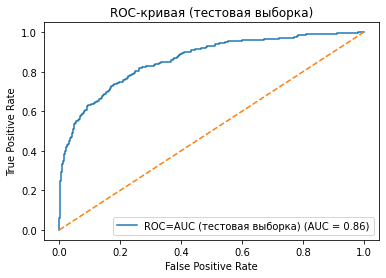

ROC-AUC (тестовая выборка):  0.8608292647488903


0.8608292647488903

In [79]:
roc_auc_viz(best_rfc, features_test, target_test, sample_name='тестовая выборка')

**Выводы:**
- для устранения дисбаланса в обучающей выборке увеличено число клиентов, ушедших из банка
- лучшей моделью с точки зрения F1-меры и ROC-AUC оказался случайный лес с 200 обученными деревьями и глубиной дерева 10.
- после работы с дисбалансом классов удалось довести значение F1-меры до 0,61 и ROC-AUC до 0,85 в валидационной выборке, F1-меру до 0,6 и ROC-AUC до 0,86 в тестовой выборке
- в дальнейшем можно поэкспериментировать с подбором других гиперпараметров разных моделей и параметром кроссвалидации (cv) в GridSearchCV, применить другие алгоритмы (например, KNN), чтобы улучшить предсказуемость ухода клиентов из банка, а также избежать проблем с переобучением

## Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнен шаг 1: данные подготовлены
- [x]  Выполнен шаг 2: задача исследована
    - [x]  Исследован баланс классов
    - [x]  Изучены модели без учёта дисбаланса
    - [x]  Написаны выводы по результатам исследования
- [x]  Выполнен шаг 3: учтён дисбаланс
    - [x]  Применено несколько способов борьбы с дисбалансом
    - [x]  Написаны выводы по результатам исследования
- [x]  Выполнен шаг 4: проведено тестирование
- [x]  Удалось достичь *F1*-меры не менее 0.59
- [x]  Исследована метрика *AUC-ROC*